## Importing implementation of DBN in pytorch

In [1]:
def get_dbn_library():
  files = ["DBN.py", "RBM.py"]
  repository_url = "https://raw.githubusercontent.com/flavio2018/Deep-Belief-Network-pytorch/master/"
  for file in files:
    !wget -O {file} {repository_url}{file}

In [2]:
%%capture
get_dbn_library()

## Importing required libraries

In [146]:
import math
import random
import pylab
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import seaborn as sn
import torchvision as tv
import torchvision.transforms as transforms
import torch.optim as optim
import time
import scipy.cluster as cluster
import torch.nn as nn
torch.set_printoptions(linewidth=120)
from DBN import DBN
from tqdm import tqdm
from scipy.stats import norm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report

In [4]:
print(torch.cuda.is_available())
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

True


## Loading data and Visualizing

Here we load the dataset and randomly visualize some of the data to ensure that everything works fine.

In [5]:
%%capture
FashionMNIST_train = tv.datasets.FashionMNIST('data/', train=True, download=True,
                                         transform=tv.transforms.Compose(
                                                  [tv.transforms.ToTensor()]))

FashionMNIST_test = tv.datasets.FashionMNIST("data/", train=False, download=True,
                                transform=tv.transforms.Compose(
                                        [tv.transforms.ToTensor()]))

In [6]:
data_loader = torch.utils.data.DataLoader(FashionMNIST_train, batch_size=10, shuffle=True)
sample = next(iter(data_loader))
imgs, lbls = sample

image tensor: torch.Size([10, 1, 28, 28])
class labels: tensor([6, 3, 1, 3, 1, 3, 4, 1, 2, 6])


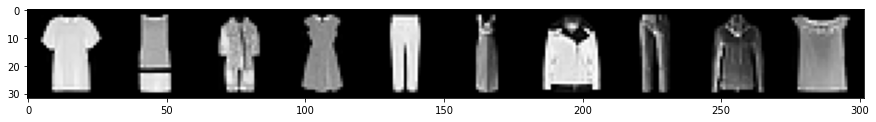

In [7]:
plt.figure(figsize=(15,10))
grid = tv.utils.make_grid(nrow=20, tensor=imgs)
print(f"image tensor: {imgs.shape}")
print(f"class labels: {lbls}")
plt.imshow(np.transpose(grid, axes=(1,2,0)), cmap='gray')

## Rescaling the dataset

We have to decide how to rescale our dataset. we have Two options available: Standardization and Normalization. If our data points follow the gaussian (normal) distribution we should use standardization otherwise, normalization works better.

In [8]:
FashionMNIST_train.data = np.array(FashionMNIST_train.data)
FashionMNIST_test.data = np.array(FashionMNIST_test.data)

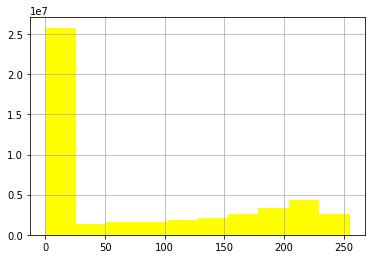

In [9]:
one_d_train = FashionMNIST_train.data.ravel()
temp_data = pd.Series(one_d_train)
temp_data.hist(color='yellow')

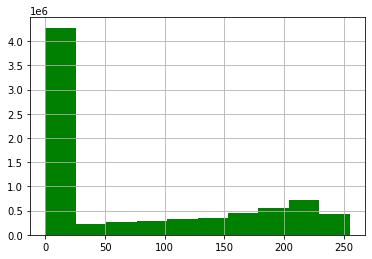

In [10]:
one_d_test = FashionMNIST_test.data.ravel()
temp_data = pd.Series(one_d_test)
temp_data.hist(color='green')

It is obvious that our dataset does not follow the gaussian (normal) distribution, so in this case, normalization works better than standardization.

In [11]:
scaler = MinMaxScaler()

one_d_train = scaler.fit_transform(one_d_train.reshape(-1, 1))
one_d_test = scaler.fit_transform(one_d_test.reshape(-1, 1))

Now we transform NumPy arrays to the default structure of torch tensors.

In [12]:
FashionMNIST_train.data = torch.from_numpy(one_d_train.ravel().reshape(60000, 28, 28))

FashionMNIST_test.data = torch.from_numpy(one_d_test.ravel().reshape(10000, 28, 28))

## Training the model

In this section, we have to design our DBN model and choose the optimal number of layers and neurons. One of the best architectures I found with some research is Two hidden layer with 500 neurons.

Reference: https://www.researchgate.net/publication/280125595_Robustness_of_spiking_Deep_Belief_Networks_to_noise_and_reduced_bit_precision_of_neuro-inspired_hardware_platforms

In [13]:
dbn_FashionMNIST= DBN(visible_units=784,
                hidden_units=[500, 500],
                k=1,
                learning_rate=0.1,
                learning_rate_decay=False,
                initial_momentum=0.5,
                final_momentum=0.95,
                weight_decay=0.0001,
                use_gpu=torch.cuda.is_available())

And we train our DBN model with 200 epochs and batch size 64.

In [14]:
num_epochs = 200
batch_size = 64

dbn_FashionMNIST.train_static(
    FashionMNIST_train.data,
    FashionMNIST_train.targets,
    num_epochs,
    batch_size
)

--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.0445     |0.0665       |315.6562   |6.6307     |
|20    |1.0251     |0.0660       |318.2706   |7.3886     |
|30    |1.0144     |0.0656       |304.3422   |6.7829     |
|40    |1.0284     |0.0664       |292.8869   |6.2188     |
|50    |1.0284     |0.0658       |279.1274   |5.9352     |
|60    |1.0302     |0.0676       |276.1107   |5.8919     |
|70    |1.0409     |0.0674       |271.5812   |5.4059     |
|80    |1.0516     |0.0669       |268.2446   |6.4973     |
|90    |1.0499     |0.0674       |264.0455   |6.2081     |
|100    |1.0539     |0.0686       |263.6803   |6.8862     |
|110    |1.0586     |0.0688       |255.8575   |5.6288     |
|120    |1.0668     |0.0678       |246.0373   |5.0990     |
|130    |1.0750     |0.0698       |239.8184   |5.5479     |
|140    |1.0768     |0.0701       |236.5519   |5.4087     |
|150    |1.0823     |0.0705       |234.6854   |5.0190     |
|160    |

## Clustering internal representations

Then, we want to examine the properties of the learned representations. Therefore, we will compute the centroid of the representations learned for each class, and see how close they are one to the other using a standard hierarchical clustering algorithm.

In [15]:
# Here we get the representation of the each hidden layer.

def get_kth_layer_repr(input, k, device):
  flattened_input = input.view((input.shape[0], -1)).type(torch.FloatTensor).to(device)
  hidden_repr, __ = dbn_FashionMNIST.rbm_layers[k].to_hidden(flattened_input)
  return hidden_repr

Of course, the representations computed using the second layer are computed using the ones from the first layer:

We have 60000 train data so the shape of representation is 60000 * number of neurons in kth hidden layer.

In [16]:
hidden_repr_layer_1 = get_kth_layer_repr(FashionMNIST_train.data, 0, device)
hidden_repr_layer_2 = get_kth_layer_repr(hidden_repr_layer_1, 1, device)

Finally, we compute the centroid (mean) of the representations of each class and we build a matrix containing all the centroids to comply with the input required by the clustering algorithm.

In [17]:
def get_mask(label):
  labels = FashionMNIST_train.targets.cpu().numpy()
  return labels == label

def get_label_to_mean_hidd_repr(hidden_representation):
  hidden_representation_np = hidden_representation.cpu().numpy()
  return {
    label: hidden_representation_np[get_mask(label)].mean(axis=0)
    for label in range(10)
  }

def get_hidden_reprs_matrix(hidden_representation):
  label_to_mean_hidd_repr = get_label_to_mean_hidd_repr(hidden_representation)
  return np.concatenate(
    [np.expand_dims(label_to_mean_hidd_repr[label], axis=0)
    for label in range(10)])

In [18]:
# Here we create a matrix for each layer with the shape of 10 (number of labels) * number of neurons in kth hidden layer.

mean_hidd_repr_matrix_1 = get_hidden_reprs_matrix(hidden_repr_layer_1)
mean_hidd_repr_matrix_2 = get_hidden_reprs_matrix(hidden_repr_layer_2)

In [19]:
def plot_dendrogram(mean_repr_matrix, title):
  fig, ax = plt.subplots()
  linkage = cluster.hierarchy.linkage(mean_repr_matrix, method="complete")
  dendrogram = cluster.hierarchy.dendrogram(linkage)
  ax.set_title(title)

In this section, we plot the dendrogram for each layer and it will be described in how we should interpret it.

The Y-axis represents the number of labels and the X-axis represents the range of numbers in the mean hidden representation matrix. we can find out that based on the first hidden layer label 1 and 3 have more similarity. In addition labels 9, 5, and 7 have more similarity and labels 0, 8, 4, 2, and 6 have more similarity.

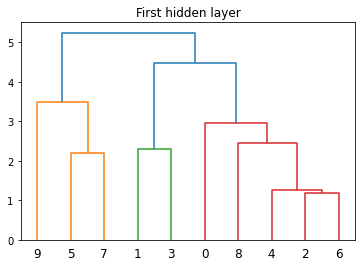

In [20]:
plot_dendrogram(mean_hidd_repr_matrix_1, "First hidden layer")

Based on what we described, we can observe a little difference in the second layer and also we can consider it as an improvement on the previous one.

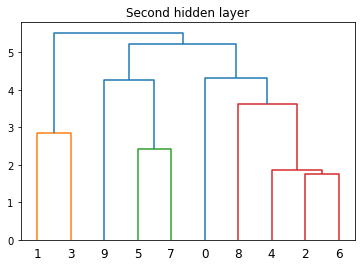

In [21]:
plot_dendrogram(mean_hidd_repr_matrix_2, "Second hidden layer")

## Linear read-out

We can now extract the hidden representations of the data, by propagating the neuron's activations from the sensory (visible) layer in a bottom-up fashion, and try to lineary decode the content of the representations in a supervised way.

In [22]:
class LinearModel(torch.nn.Module):
  def __init__(self, layer_size):
    super().__init__()
    self.linear = torch.nn.Linear(layer_size, 10)

  def forward(self, x):
    return self.linear(x)

Here we convert each hidden layer to a linear model.

In [23]:
layer_size = dbn_FashionMNIST.rbm_layers[0].W.shape[1]
linear1 = LinearModel(layer_size).to(device)

layer_size = dbn_FashionMNIST.rbm_layers[1].W.shape[1]
linear2 = LinearModel(layer_size).to(device)

Here we train our linear model with the representations we obtained from the previous section.

In [24]:
def fit(linear, hidden_reprs):
  # We choose Adam optimizing algorithm with learning rate 0.0005 becasue it is an
  # adaptive learning rate method and is combination of RMSprop and Stochastic Gradient Descent with momentum.

  optimizer = optim.Adam(linear.parameters(), lr=0.0005)
  loss_fn = torch.nn.CrossEntropyLoss()
  epochs = 2000

  for epoch in range(1, epochs + 1):
    optimizer.zero_grad()
    predictions = linear(hidden_reprs).squeeze()
    targets = FashionMNIST_train.targets.reshape(predictions.shape[0]).to(device)
    loss = loss_fn(predictions, targets)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
      print("epoch : {:3d}/{}, loss = {:.4f}".format(epoch, epochs, loss))

And in this section we train each hidden layer separately.

In [25]:
fit(linear1, hidden_repr_layer_1)
print('End of first layer', end="\n\n")
fit(linear2, hidden_repr_layer_2)
print('End of second layer', end="\n\n")

epoch : 100/2000, loss = 1.5157
epoch : 200/2000, loss = 1.1104
epoch : 300/2000, loss = 0.9047
epoch : 400/2000, loss = 0.7877
epoch : 500/2000, loss = 0.7135
epoch : 600/2000, loss = 0.6622
epoch : 700/2000, loss = 0.6246
epoch : 800/2000, loss = 0.5956
epoch : 900/2000, loss = 0.5726
epoch : 1000/2000, loss = 0.5538
epoch : 1100/2000, loss = 0.5382
epoch : 1200/2000, loss = 0.5249
epoch : 1300/2000, loss = 0.5134
epoch : 1400/2000, loss = 0.5035
epoch : 1500/2000, loss = 0.4947
epoch : 1600/2000, loss = 0.4868
epoch : 1700/2000, loss = 0.4798
epoch : 1800/2000, loss = 0.4735
epoch : 1900/2000, loss = 0.4677
epoch : 2000/2000, loss = 0.4625
End of first layer

epoch : 100/2000, loss = 1.0299
epoch : 200/2000, loss = 0.7174
epoch : 300/2000, loss = 0.6039
epoch : 400/2000, loss = 0.5449
epoch : 500/2000, loss = 0.5084
epoch : 600/2000, loss = 0.4833
epoch : 700/2000, loss = 0.4650
epoch : 800/2000, loss = 0.4510
epoch : 900/2000, loss = 0.4398
epoch : 1000/2000, loss = 0.4307
epoch : 

As it is obvious, the value of loss in last epoch of second hidden layer is less than the first layer which means the DBN model performance is optimized.

Here we use FashionMnist test dataset to calculate the accuracy of each hidden layer we trained separately.

In [26]:
hidden_repr_layer_1_test = get_kth_layer_repr(FashionMNIST_test.data, 0, device)
hidden_repr_layer_2_test = get_kth_layer_repr(hidden_repr_layer_1_test, 1, device)

In [27]:
predictions_test1 = linear1(hidden_repr_layer_1_test).to(device)
predictions_test2 = linear2(hidden_repr_layer_2_test).to(device)

In [28]:
def compute_accuracy(predictions_test, targets):
  predictions_indices = predictions_test.max(axis=1).indices
  accuracy = (predictions_indices == targets).sum() / len(targets)
  return accuracy.item()

In [29]:
compute_accuracy(predictions_test1, FashionMNIST_test.targets.to(device))

0.8253999948501587

In [30]:
compute_accuracy(predictions_test2, FashionMNIST_test.targets.to(device))

0.8490999937057495

The accuracy values are adequate and obviously the second layer is more efficient.

## Comparison with a feed-forward model

Now we train a simple feed-forward neural network with the same structure of the DBN, in order to compare a non-linear model that is trained end-to-end to solve a classification task with a simple linear classifier that solves the same task using representations of input data learned in an unsupervised way.

In [31]:
class Feedforward(torch.nn.Module):
    def __init__(self, first_hidden_layer_size, second_hidden_layer_size):
        super().__init__()
        self.first_hidden_layer = torch.nn.Linear(784, first_hidden_layer_size)
        self.second_hidden_layer = torch.nn.Linear(first_hidden_layer_size, second_hidden_layer_size)
        # output layer
        self.output = torch.nn.Linear(second_hidden_layer_size, 10)
        
    def forward(self, input):
        # We use GELU activation function as a extend of RELU to obtain better result.
        gelu = torch.nn.GELU()

        # Flatten the image tensors
        flatten_out = input.view(input.size(0), -1).to(torch.float32)

        # Get intermediate outputs using hidden layer 1
        first_hidden_out = self.first_hidden_layer(flatten_out)
        # Apply activation function
        out = gelu(first_hidden_out)

        # Get intermediate outputs using hidden layer 2
        second_hidden_out = self.second_hidden_layer(out)
        # Apply activation function
        out = gelu(second_hidden_out)
        
        # Get predictions using output layer
        return self.output(out)      

Here we pass the same architecture of DBN to our linear feedforward model.

In [32]:
ffnn = Feedforward(500, 500).to(device)

We train the feedforward model here.

In [33]:
fit(ffnn, FashionMNIST_train.data.reshape((60000, 784)).to(device))

epoch : 100/2000, loss = 0.4235
epoch : 200/2000, loss = 0.3508
epoch : 300/2000, loss = 0.3082
epoch : 400/2000, loss = 0.2746
epoch : 500/2000, loss = 0.2487
epoch : 600/2000, loss = 0.2293
epoch : 700/2000, loss = 0.2075
epoch : 800/2000, loss = 0.1893
epoch : 900/2000, loss = 0.1749
epoch : 1000/2000, loss = 0.1604
epoch : 1100/2000, loss = 0.1463
epoch : 1200/2000, loss = 0.1367
epoch : 1300/2000, loss = 0.1252
epoch : 1400/2000, loss = 0.1152
epoch : 1500/2000, loss = 0.1056
epoch : 1600/2000, loss = 0.0978
epoch : 1700/2000, loss = 0.0905
epoch : 1800/2000, loss = 0.0853
epoch : 1900/2000, loss = 0.0780
epoch : 2000/2000, loss = 0.0712


We observe that the loss value has significantly decreased by the feedforward model.

Then we use the trained model to predict test dataset targets and finally calculate the accuracy.

In [34]:
predictions_ffnn = ffnn(FashionMNIST_test.data.reshape((10000, 784)).to(device))

In [35]:
compute_accuracy(predictions_ffnn, FashionMNIST_test.targets.to(device))

0.8859999775886536

This accuracy demonstrate an adequate improvement in comparison to linear read-out.

## Visualizing the confusion matrices

In this section, we want to visualize the confusion matrix for linear read-out layers and the feed-forward model to observe the progress of our supervised learning.

First, we visualize the confusion matrix of linear read-out layers.
The first plot is for the first hidden layer.

              precision    recall  f1-score   support

           0       0.77      0.78      0.78      1000
           1       0.98      0.93      0.96      1000
           2       0.72      0.72      0.72      1000
           3       0.82      0.85      0.84      1000
           4       0.72      0.75      0.73      1000
           5       0.96      0.90      0.93      1000
           6       0.57      0.54      0.55      1000
           7       0.89      0.91      0.90      1000
           8       0.93      0.95      0.94      1000
           9       0.90      0.94      0.92      1000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



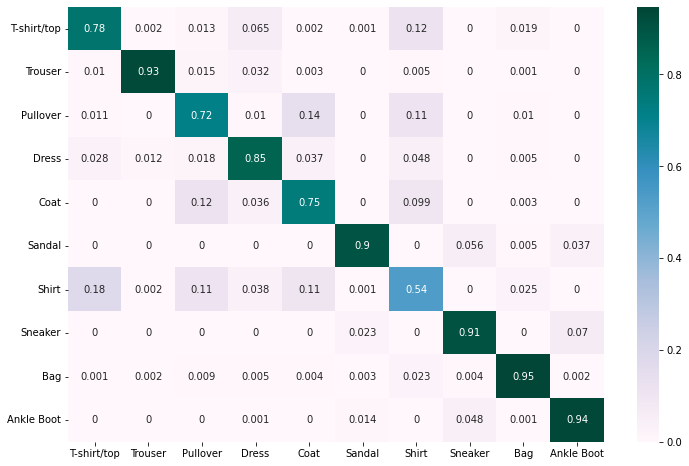

In [36]:
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

actual_labels = FashionMNIST_test.targets.to(device).cpu().numpy()
predicted_labels = predictions_test1.cpu().detach().max(axis=1).indices.numpy()

cf_matrix = confusion_matrix(actual_labels, predicted_labels)

df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) * 10, index = [i for i in classes], columns = [i for i in classes])
plt.figure(figsize = (12,8))
sn.heatmap(df_cm, cmap="PuBuGn", annot=True)

print(classification_report(actual_labels, predicted_labels))

As we can see, this model shows approximately good accuracy, precision, and F1-score based on the confusion matrix and classification report.

Next, we plot the second confusion matrix for the second hidden layer.

              precision    recall  f1-score   support

           0       0.80      0.81      0.80      1000
           1       0.99      0.95      0.97      1000
           2       0.74      0.76      0.75      1000
           3       0.86      0.88      0.87      1000
           4       0.74      0.77      0.75      1000
           5       0.96      0.93      0.94      1000
           6       0.62      0.57      0.60      1000
           7       0.91      0.93      0.92      1000
           8       0.95      0.96      0.95      1000
           9       0.92      0.94      0.93      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



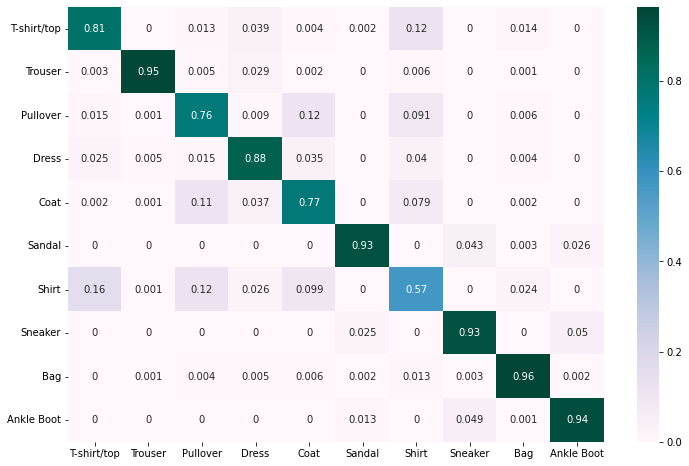

In [37]:
actual_labels = FashionMNIST_test.targets.to(device).cpu().numpy()
predicted_labels = predictions_test2.cpu().detach().max(axis=1).indices.numpy()

cf_matrix = confusion_matrix(actual_labels, predicted_labels)

df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) * 10, index = [i for i in classes], columns = [i for i in classes])
plt.figure(figsize = (12,8))
sn.heatmap(df_cm, cmap="PuBuGn", annot=True)

print(classification_report(actual_labels, predicted_labels))

We can observe that the accuracy, precision, and F1-score have improved by around 1% on average.

Finally, we plot it for the feed-forward model.

              precision    recall  f1-score   support

           0       0.81      0.83      0.82      1000
           1       0.98      0.97      0.97      1000
           2       0.84      0.82      0.83      1000
           3       0.88      0.88      0.88      1000
           4       0.82      0.84      0.83      1000
           5       0.96      0.95      0.96      1000
           6       0.72      0.71      0.71      1000
           7       0.93      0.95      0.94      1000
           8       0.97      0.96      0.96      1000
           9       0.96      0.94      0.95      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



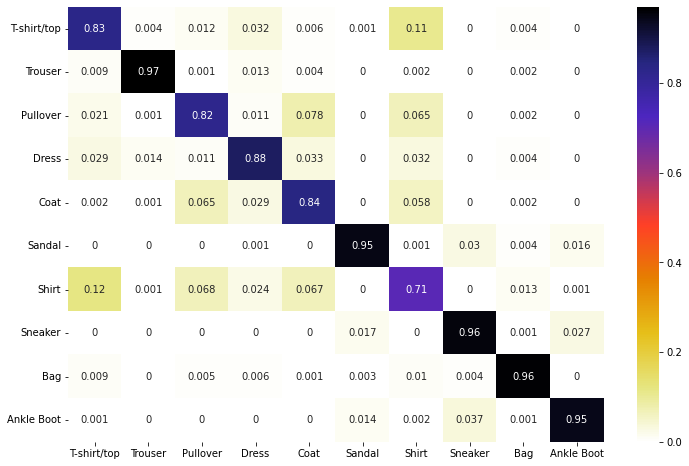

In [38]:
actual_labels = FashionMNIST_test.targets.to(device).cpu().numpy()
predicted_labels = predictions_ffnn.cpu().detach().max(axis=1).indices.numpy()

cf_matrix = confusion_matrix(actual_labels, predicted_labels)

df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) * 10, index = [i for i in classes], columns = [i for i in classes])
plt.figure(figsize = (12,8))
sn.heatmap(df_cm, cmap="CMRmap_r", annot=True)

print(classification_report(actual_labels, predicted_labels))

As it is obvious, in the FFNN model the accuracy, precision, and F1-score improved in comparison with the linear read-out model.

## Visualizing the psychometric curves

We will now inject some noise in the input images and see how much the representations learned by the DBN and the feed-forward network are robust to perturbations in the sensory signal.

Similarly to what happens in psychophysical experiments, this will allow to create a psychometric curve describing the decrease in classification accuracy with respect to the noise level.

In this section, create a function that adds some Gaussian noise to the MNIST data.

In [39]:
def inject_noise(FashionMNIST_data, noise_level):
  X_train_noise = FashionMNIST_data + noise_level * np.random.normal(loc=0.0, scale=1.1, size=FashionMNIST_data.shape) 
  return(X_train_noise.to(device))

Here we see what a noisy image looks like:

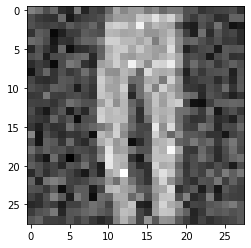

In [40]:
noise_level = 0.2
Fashion_test_with_noise = inject_noise(FashionMNIST_test.data, noise_level)
__ = plt.imshow(Fashion_test_with_noise[2].reshape(28, 28).to("cpu"))

We will now compute the hidden representations for the noisy images using the DBN. Then, we will use the read-out classifiers that we trained on the representations without noise to classify the noisy images.

In [41]:
def get_accuracy_values_at_noise_level(noise_level):

  # First, we create noisy test images
  Fashion_test_with_noise = inject_noise(FashionMNIST_test.data, noise_level)
  
  # Here we compute the DBN representations
  hidden_repr_layer_1_noisy = get_kth_layer_repr(Fashion_test_with_noise, 0, device)
  hidden_repr_layer_2_noisy = get_kth_layer_repr(hidden_repr_layer_1_noisy, 1, device)
  
  # Here we use the previously-trained read-out classifiers
  predictions_first_hidden_noisy = linear1(hidden_repr_layer_1_noisy)
  predictions_second_hidden_noisy = linear2(hidden_repr_layer_2_noisy)
  
  accuracy_first_hidden = compute_accuracy(predictions_first_hidden_noisy, FashionMNIST_test.targets.to(device))
  accuracy_second_hidden = compute_accuracy(predictions_second_hidden_noisy, FashionMNIST_test.targets.to(device))
  
  # Here we use the previously-trained FFNN classifiers
  predictions_ffnn_noisy_data = ffnn(Fashion_test_with_noise)
  accuracy_ffnn = compute_accuracy(predictions_ffnn_noisy_data, FashionMNIST_test.targets.to(device))

  return accuracy_first_hidden, accuracy_second_hidden, accuracy_ffnn

We check the accuracy of the linear read-out and feed-forward models.

In [45]:
acc = get_accuracy_values_at_noise_level(noise_level);
print("Accuracy of H1 read-out: %.3f" % acc[0])
print("Accuracy of H2 read-out: %.3f" % acc[1])
print("Accuracy of FFNN: %.3f" % acc[2])

Accuracy of H1 read-out: 0.810
Accuracy of H2 read-out: 0.837
Accuracy of FFNN: 0.534


Now we create the psychometric curves for the DBN (at different levels of internal representations) and for the feed-forward network.

In [42]:
def plot_noise_robustness_curves(noise_levels):
  accuracy_values_first_hidden = []
  accuracy_values_second_hidden = []
  accuracy_values_ffnn = []

  for noise_level in noise_levels:
    acc = get_accuracy_values_at_noise_level(noise_level)
    accuracy_values_first_hidden.append(acc[0])
    accuracy_values_second_hidden.append(acc[1])
    accuracy_values_ffnn.append(acc[2])

  fig, ax = plt.subplots()
  ax.plot(range(len(noise_levels)), accuracy_values_first_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_second_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_ffnn)

  ax.set_title("Robustness to noise")
  ax.set_xlabel("Noise level (%)")
  ax.set_ylabel("Accuracy")
  plt.xticks(range(len(noise_levels)), [int(l*100) for l in noise_levels])
  plt.legend(["First hidden", "Second hidden", "FFNN"])

And finally, we plot the curve of learning by increasing the level of noise.

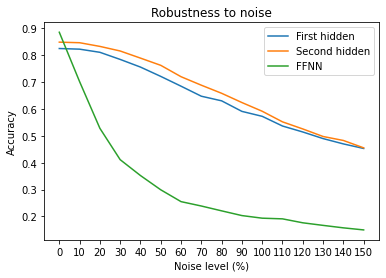

In [43]:
noise_levels = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]
plot_noise_robustness_curves(noise_levels)

As we can see, the FFNN model will be affected by the noise levels very much and it will be highly sensitive when we increase the noise levels. (Accuracy is suddenly diminished by increasing the noise levels)

On the other hand, the situation is different with the linear read-out model. In comparison with the FFNN model, it will not be affected very much but as we already know the second hidden layer is more precise so as a result, it is more sustainable against the noise in comparison with the first hidden layer.

## Add some noises and adversarial attacks

In general, with adversarial attacks we try to modify the input so that the model cannot correctly classify it anymore. This means that the loss for that specific input has to increase.

The loss is usually a function of the input, the model's parameters and the outputs: $J(w, x, y)$.

When we are training the model, we modify the model's weights based on the value of the gradient of the loss function, using the opposite direction w.r.t. the gradient because we want the loss to decrease. To create an adversarial sample we change two things in this procedure: 
1. we modify the input instead of the model's weights;
2. we go in the same direction as the gradient, since we want the loss function to increase.

The adversarial sample will then look like:

$\tilde{x} = x + \epsilon \cdot \text{sign}(\nabla_{x} J(w, x, y))$

Here we implement a simple FGSM attack.

In [105]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()

    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad

    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    # Return the perturbed image
    return perturbed_image

In this section we implement DBN read-out version.

In [106]:
class DBNWithReadOut(torch.nn.Module):
    def __init__(self, dbn_FashionMNIST, readouts, readout_level=0):
        super().__init__()
        self.readouts = readouts
        self.dbn_FashionMNIST = dbn_FashionMNIST
        self._require_grad()
        self.readout_level = readout_level

    def _require_grad(self):
      for rbm in self.dbn_FashionMNIST.rbm_layers:
        rbm.W.requires_grad_()
        rbm.h_bias.requires_grad_()

    def forward(self, image):
      """This forward pass uses probabilities instead of samples as RBM outputs
       to backpropagate the gradient"""
      p_v = image
      hidden_states = []
      for rbm in self.dbn_FashionMNIST.rbm_layers:
        p_v = p_v.view((p_v.shape[0], -1))
        p_v, v = rbm(p_v)
        hidden_states.append(p_v)
      return self.readouts[self.readout_level].forward(hidden_states[self.readout_level])

In [107]:
dbn_with_readout = DBNWithReadOut(dbn_FashionMNIST, [linear1, linear2], readout_level=1)

Here we see what an adversiarial sample looks like. Let't take one sample from the test set:

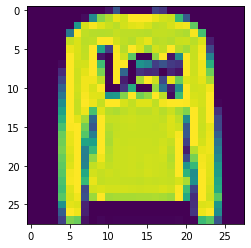

In [108]:
test_sample_idx = 1
test_image = FashionMNIST_test.data[test_sample_idx].reshape(1, 784)
__ = plt.imshow(test_image.reshape(28,28).to('cpu'))

Here we classify this "clean" image using one of the models we previously trained and then modify the image to attack the network.

To change the model we attack, you can modify the value of the model variable in the cell below.

In [109]:
attacked_model = ffnn

In [110]:
test_image.requires_grad_()
model_outputs = attacked_model(test_image.to(device))
prediction = torch.argmax(model_outputs)
print(f"The prediction of the model for this clean sample is {prediction}.")

The prediction of the model for this clean sample is 2.


In this section, we configure the attack and noising settings

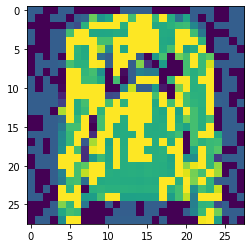

In [111]:
# We define strenght of the attack
epsilon = 0.3

# Getting the ground truth label for that image
test_image_label = FashionMNIST_test.targets[test_sample_idx].unsqueeze(0)

# Getting the loss value
loss_value = torch.nn.functional.cross_entropy(model_outputs.to(device), test_image_label.to(device))
attacked_model.zero_grad()
loss_value.backward()

# Getting the gradient of the pixels w.r.t. the loss
image_grad = test_image.grad.data
perturbed_image = fgsm_attack(test_image, epsilon, image_grad)

perturbed_image_np = perturbed_image.detach().to('cpu').numpy()
__ = plt.imshow(perturbed_image_np.reshape(28,28))

We check the prediction result here:

In [112]:
model_outputs = attacked_model(perturbed_image.to(device).view((perturbed_image.shape[0], -1)))
print(f"The prediction of the model for the perturbed sample is {torch.argmax(model_outputs)}.")

The prediction of the model for the perturbed sample is 4.


We can observe that the algorithm is confused and make the prediction wrong. (Actual label is 2 but the prediction is 4).

## Resisting to adversarial attacks

Let's now compare the ability to resist adversarial attacks of our two models: the feedforward network and the DBN.

We will also test the ability of the DBN to reduce the impact of the attack by performing one "top-down" reconstruction step, from the hidden representation of the last layer to the visible units, and back to the hidden representation.

In [184]:
def test_robustness_to_attack(model, device, test_loader, epsilon, num_steps=0, verbose=True):
    correct = 0
    print_reconstruction = num_steps > 0

    for data, target in tqdm(test_loader):
        data, target = data.to(device), target.to(device)
        data = data.reshape(-1, 784)
        data.requires_grad = True
        
        output = model.forward(data)

        init_pred = torch.argmax(output)
        
        if (print_reconstruction and verbose):
          print("\nHere's the original sample:\n")
          plt.imshow(data[0].detach().to('cpu').numpy().reshape(28,28))
          plt.show()

        loss = nn.functional.nll_loss(output, target)
        model.zero_grad()
        loss.backward()
        # Collect the gradient of the input data
        data_grad = data.grad.data
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        if (print_reconstruction and verbose):
            print("\nHere's a perturbed sample:\n")
            plt.imshow(perturbed_data[0].detach().to('cpu').numpy().reshape(28,28))
            plt.show()


        # If requested, reconstruct the input iterating forward-backward dynamics
        if num_steps > 0:
            for __ in range(0, num_steps):
                perturbed_data, __ = model.dbn_FashionMNIST.reconstruct(perturbed_data)
            if (print_reconstruction and verbose):
                print(f"\nHere's what a {num_steps}-steps reconstructed sample looks like:\n")
                plt.imshow(perturbed_data[0].detach().to('cpu').numpy().reshape(28,28))
                plt.show()
                print_reconstruction = False

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        # Get the index of the max element in the output
        final_pred = output.max(1, keepdim=True)[1]
        final_pred = output.argmax(-1)
        correct += (final_pred == target).sum()

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader.sampler))
    print("\nEpsilon: {}\nTest Accuracy: {:.2f}%\n".format(epsilon, final_acc*100))

    return final_acc.item()

In [185]:
test_loader = torch.utils.data.DataLoader(
    tv.datasets.FashionMNIST('data/', train=False, download=False, transform=tv.transforms.Compose([tv.transforms.ToTensor()])),
    batch_size=100, shuffle=True)

In [186]:
final_acc1 = test_robustness_to_attack(ffnn, device, test_loader, epsilon=0.05, num_steps=0)

100%|██████████| 100/100 [00:01<00:00, 97.86it/s]


Epsilon: 0.05
Test Accuracy: 3.09%



In [187]:
final_acc2 = test_robustness_to_attack(dbn_with_readout, device, test_loader, epsilon=0.05, num_steps=0)

100%|██████████| 100/100 [00:01<00:00, 87.38it/s]


Epsilon: 0.05
Test Accuracy: 69.46%



In [188]:
epsilon_values = [0, 0.1, 0.2, 0.3, 0.4, 0.5]

def test_epsilon_values_effect(model, n_steps):
  accuracies = list()

  for eps in epsilon_values:
      acc = test_robustness_to_attack(model, device, test_loader, eps, num_steps=n_steps, verbose=False)
      accuracies.append(acc)

  return accuracies

In [189]:
%%capture
accuracies_ffnn = test_epsilon_values_effect(ffnn, n_steps=0)
accuracies_dbn_0 = test_epsilon_values_effect(dbn_with_readout, n_steps=0)
accuracies_dbn_1 = test_epsilon_values_effect(dbn_with_readout, n_steps=1)

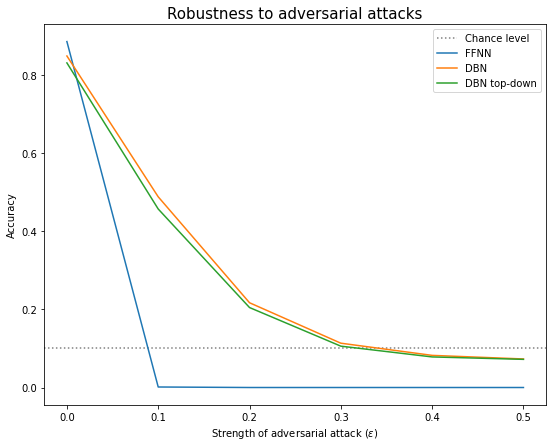

In [190]:
fig, ax = plt.subplots(1, 1, figsize=(9, 7), sharey=True)

__ = ax.axhline(0.1, color='gray', linestyle=':')
__ = ax.plot(epsilon_values, accuracies_ffnn)
__ = ax.plot(epsilon_values, accuracies_dbn_0)
__ = ax.plot(epsilon_values, accuracies_dbn_1)
__ = ax.set_xlabel("Strength of adversarial attack ($\epsilon$)")
__ = ax.set_ylabel("Accuracy")
__ = ax.set_title("Robustness to adversarial attacks", {'fontsize': 15})
__ = ax.legend(["Chance level", "FFNN", "DBN", "DBN top-down"])

As a result, robustness to adversarial attacks in the DBN system is much better than the FFNN model and it can resist better against attacks.

## Final conclusion

The FFNN model as a supervised system could be better than the linear read-out DBN in terms of prediction, but if we come to the adversarial attacks the DBN approach has a much better result.